In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix


In [32]:


df = pd.read_csv("data/driver.csv")

df['date_from'] = pd.to_datetime(df['date_from'])
df['date_to'] = pd.to_datetime(df['date_to'])

print(f"Data Loaded: {df.shape}")



Data Loaded: (11507, 23)


In [33]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11507 entries, 0 to 11506
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  11507 non-null  int64         
 1   driver_id           11507 non-null  int64         
 2   driver_ssign_id     4607 non-null   object        
 3   imei                11507 non-null  int64         
 4   date_from           11507 non-null  datetime64[ns]
 5   date_to             11507 non-null  datetime64[ns]
 6   overspeed_accuracy  11507 non-null  int64         
 7   overspeed_zone      11507 non-null  int64         
 8   overspeed_road      11507 non-null  int64         
 9   overspeed_standard  11507 non-null  int64         
 10  os_acc_distance     11507 non-null  float64       
 11  os_zo_distance      11507 non-null  int64         
 12  os_ro_distance      11507 non-null  int64         
 13  os_st_distance      11507 non-null  float64   

In [34]:
print(df.describe())


                 id     driver_id          imei  \
count  11507.000000  11507.000000  1.150700e+04   
mean    7495.740940   2674.550187  5.524061e+14   
min       13.000000      3.000000  2.159650e+09   
25%     4628.500000   1200.000000  3.540171e+14   
50%     7545.000000   2032.000000  3.596321e+14   
75%    10421.500000   3887.000000  8.646361e+14   
max    13298.000000   7752.000000  8.698670e+14   
std     3401.394728   2024.626106  3.119737e+14   

                           date_from                        date_to  \
count                          11507                          11507   
mean   2025-12-04 05:39:56.681411584  2025-12-05 01:24:41.217345792   
min              2025-11-04 00:39:48            2025-11-04 03:05:27   
25%              2025-12-02 04:00:39            2025-12-03 00:00:00   
50%              2025-12-04 05:15:20            2025-12-05 00:00:00   
75%              2025-12-07 00:00:00            2025-12-07 09:19:15   
max              2025-12-08 23:18:29       

In [35]:
# 1. Check Missing Values
missing_percentage = df.isnull().mean() * 100
print("Missing Values:")
print(missing_percentage[missing_percentage > 0])

# 2. Check Constant Columns (Zero Information)
zero_cols = [col for col in df.columns if df[col].nunique() <= 1]    
print(f"\nConstant Columns (To be dropped): {zero_cols}")

# 3. Check Driver Keys
keys_per_driver = df.groupby('driver_id')['driver_ssign_id'].nunique()
print(f"\nMax keys per driver: {keys_per_driver.max()}")

Missing Values:
driver_ssign_id    59.9635
dtype: float64

Constant Columns (To be dropped): ['overspeed_zone', 'overspeed_road', 'os_zo_distance', 'os_ro_distance', 'harsh_breaking', 'harsh_cornering', 'harsh_acceleration', 'type']

Max keys per driver: 1


In [36]:
df_check = df.copy()

#Calculate Speed Manually
df_check['calc_speed'] = df_check['distance_traveled'] / (df_check['duration_traveled'] / 3600)

quantiles = df_check['calc_speed'].quantile([0.90, 0.95, 0.99, 0.999, 1.0])
print(quantiles)

#Identify Invalid Rows (Logic Check)
check1 = df.copy()
check1['speed_check'] = check1['distance_traveled'] / (check1['duration_traveled'] / 3600)

mask_rejected = (
    (check1['speed_check'] >= 120) | 
    (check1['distance_traveled'] <= 0) | 
    (check1['duration_traveled'] <= 0)
)   
rejected_rows = check1[mask_rejected]

print(f"\nRows to be rejected (Physics Errors): {len(rejected_rows)}")
print(f" - Zero Distance: {len(rejected_rows[rejected_rows['distance_traveled'] <= 0])}")
print(f" - Impossible Speed (>120): {len(rejected_rows[rejected_rows['speed_check'] >= 120])}")
print("\nSample of rejected rows:")
print(rejected_rows[['driver_id', 'distance_traveled', 'duration_traveled', 'speed_check']].head())

0.900       56.637619
0.950       63.855099
0.990       80.482578
0.999      301.889393
1.000    98112.000000
Name: calc_speed, dtype: float64

Rows to be rejected (Physics Errors): 2405
 - Zero Distance: 2381
 - Impossible Speed (>120): 24

Sample of rejected rows:
    driver_id  distance_traveled  duration_traveled  speed_check
3          24                0.0                  0          NaN
7          20                0.0                  0          NaN
28       4148                0.0                  0          NaN
37       4184                0.0                  0          NaN
47       4257                0.0                  0          NaN



--- Correlation Matrix ---
                    overspeed_standard  overspeed_accuracy  os_st_distance  \
overspeed_standard            1.000000            0.050704        0.721215   
overspeed_accuracy            0.050704            1.000000        0.054315   
os_st_distance                0.721215            0.054315        1.000000   
os_acc_distance               0.077205            0.880202        0.092913   

                    os_acc_distance  
overspeed_standard         0.077205  
overspeed_accuracy         0.880202  
os_st_distance             0.092913  
os_acc_distance            1.000000  


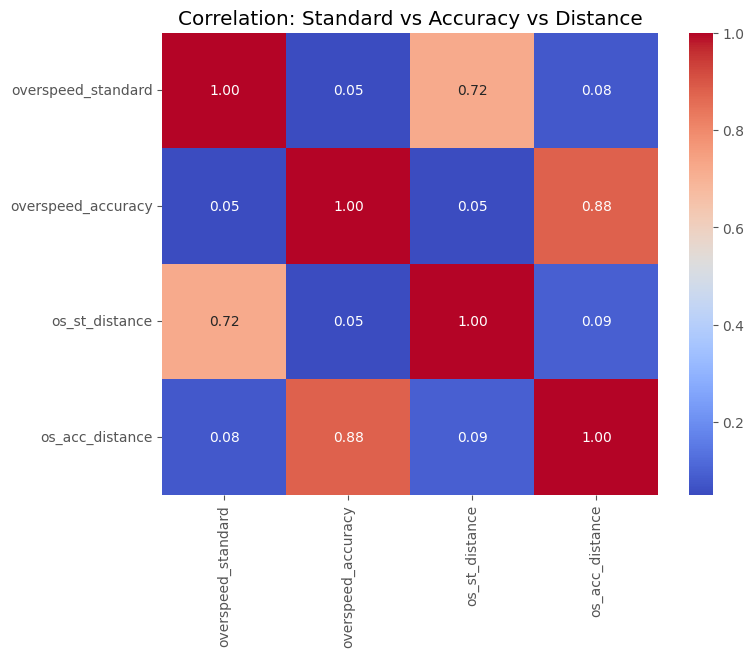

In [37]:
#Feature Selection Analysis ---

cols_to_check = ['overspeed_standard', 'overspeed_accuracy', 'os_st_distance', 'os_acc_distance']

# Calculate Correlation
correlation = df[cols_to_check].corr()
print("\n--- Correlation Matrix ---")
print(correlation)

# Visual Proof
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Standard vs Accuracy vs Distance")
plt.show()

# Justification:
# High correlation (0.74) between Standard & Distance -> Redundant.
# Low correlation (0.04) between Standard & Accuracy -> Conflicting definitions.
# Decision: Keep 'overspeed_standard' only.


--- Risk Threshold Analysis ---
Threshold (> X)    | Risky Drivers   | Percentage (%) 
-------------------------------------------------------
> 5                 | 5417            | 47.1%
> 10                | 4120            | 35.8%
> 15                | 3061            | 26.6%
> 20                | 2247            | 19.5%  <-- Selected
> 25                | 1689            | 14.7%
> 50                | 332             | 2.9%


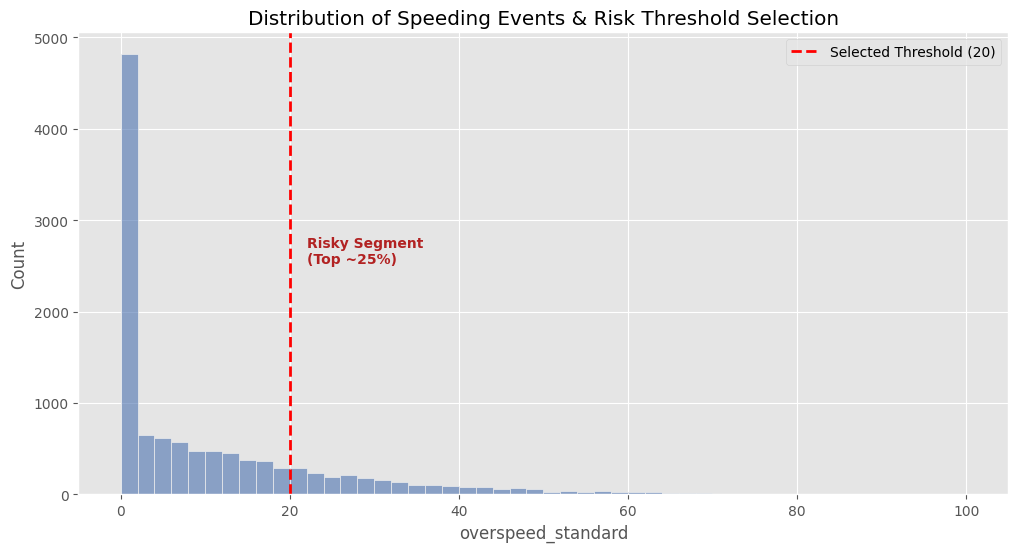

In [38]:
#Target Threshold Justification ---

# 1. Sensitivity Analysis Loop
thresholds = [5, 10, 15, 20, 25, 50]
print("\n--- Risk Threshold Analysis ---")
print(f"{'Threshold (> X)':<18} | {'Risky Drivers':<15} | {'Percentage (%)':<15}")
print("-" * 55)

for t in thresholds:
    # Use df (raw) or df_clean (if defined previously) for this check
    # Using df here to show distribution on raw data
    count = (df['overspeed_standard'] > t).sum()
    percent = (count / len(df)) * 100
    marker = "  <-- Selected" if t == 20 else ""
    print(f"> {t:<17} | {count:<15} | {percent:.1f}%{marker}")

# 2. Long-Tail Visualization
plt.figure(figsize=(12, 6))
plot_data = df[df['overspeed_standard'] <= 100]['overspeed_standard']

sns.histplot(plot_data, bins=50, kde=False, color='#4c72b0', alpha=0.6)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2, label='Selected Threshold (20)')
plt.text(22, plt.gca().get_ylim()[1]*0.5, 'Risky Segment\n(Top ~25%)', color='firebrick', fontweight='bold')

plt.title('Distribution of Speeding Events & Risk Threshold Selection')
plt.legend()
plt.show()

In [40]:
# Master Preprocessing Pipeline (Execution) ---

# 1. Start Clean
df_clean = df.copy()

# 2. Drop Columns (Based on Analysis in Cell 2 & 4)
cols_to_drop = [
    'driver_ssign_id', 'harsh_breaking', 'harsh_cornering', 'harsh_acceleration',
    'overspeed_zone', 'overspeed_road', 'os_zo_distance', 'os_ro_distance',
    'type', 'imei',
    'overspeed_accuracy', 'os_acc_distance', 'os_st_distance' 
]
df_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 3. Drop Duplicates & Apply Physics Filter (Based on Cell 3)
df_clean.drop_duplicates(inplace=True)

temp_speed = df_clean['distance_traveled'] / (df_clean['duration_traveled'] / 3600)
condition = (temp_speed < 120) & (df_clean['distance_traveled'] > 0) & (df_clean['duration_traveled'] > 0)
df_clean = df_clean[condition].copy()


df_clean['is_risky'] = (df_clean['overspeed_standard'] > 20).astype(int)

print(f"Clean Data Shape: {df_clean.shape}")

Clean Data Shape: (9102, 11)


In [41]:
df_eng = df_clean.copy()

# 1. Temporal Features
df_eng['hour'] = df_eng['date_from'].dt.hour
df_eng['day_of_week'] = df_eng['date_from'].dt.dayofweek
df_eng['is_weekend'] = df_eng['day_of_week'].isin([4, 5]).astype(int)

def get_time_category(h):
    if 7 <= h <= 9 or 16 <= h <= 19: return 1
    elif 0 <= h <= 5: return 2
    else: return 0
df_eng['time_category'] = df_eng['hour'].apply(get_time_category)

# 2. Initial Calculations (Before Repair)
# Sanity Check & Repair Logic (This was missing in your code!)
# -----------------------------------------------------------
# Fix: Ensure Idle Time isn't larger than Duration
df_eng['engine_idle'] = df_eng[['engine_idle', 'duration_traveled']].min(axis=1)
df_eng['engine_idle'] = np.where(df_eng['engine_idle'] == df_eng['duration_traveled'], 
                                 df_eng['duration_traveled'] * 0.99, 
                                 df_eng['engine_idle'])
# -----------------------------------------------------------

# 3. Derived Features (Now Safe to Calculate)
df_eng['avg_speed_kmh'] = (df_eng['distance_traveled'] / 1000) / (df_eng['duration_traveled'] / 3600)
df_eng['moving_time_sec'] = df_eng['duration_traveled'] - df_eng['engine_idle']
df_eng['moving_speed_kmh'] = (df_eng['distance_traveled'] / 1000) / (df_eng['moving_time_sec'] / 3600 + 1e-6)

# Clip outliers for Moving Speed (Fix crazy numbers)
df_eng.loc[df_eng['moving_speed_kmh'] > 200, 'moving_speed_kmh'] = 200
df_eng.loc[df_eng['moving_speed_kmh'] < 0, 'moving_speed_kmh'] = 0

df_eng['idle_ratio'] = df_eng['engine_idle'] / (df_eng['duration_traveled'] + 1e-6)
df_eng['work_per_km'] = df_eng['engine_work'] / (df_eng['distance_traveled'] / 1000 + 1e-6)
df_eng['seatbelt_ratio'] = df_eng['seat_belt'] / (df_eng['duration_traveled'] + 1e-6)

# 4. Aggregations Per Driver
df_eng['driver_avg_moving_speed'] = df_eng.groupby('driver_id')['moving_speed_kmh'].transform('mean')
df_eng['driver_total_km'] = df_eng.groupby('driver_id')['distance_traveled'].transform('sum') / 1000
df_eng['driver_risk_tendency'] = df_eng.groupby('driver_id')['overspeed_standard'].transform('mean')
df_eng['driver_seatbelt_habit'] = df_eng.groupby('driver_id')['seat_belt'].transform('mean')

# 5. Weighted Risk Score
df_eng['context_weight'] = 1.0
df_eng.loc[df_eng['time_category'] == 2, 'context_weight'] = 2.0
df_eng.loc[df_eng['time_category'] == 1, 'context_weight'] = 1.5

df_eng['weighted_risk_score'] = (
    (df_eng['overspeed_standard'] * df_eng['context_weight']) + 
    (df_eng['idle_ratio'] * 10) +
    (df_eng['seatbelt_ratio'] * 20) 
)

# 6. Fatigue
df_eng['trip_hours'] = df_eng['duration_traveled'] / 3600
df_eng['is_fatigued'] = (df_eng['trip_hours'] > 4).astype(int)

# Final Cleanup
df_eng.replace([np.inf, -np.inf], 0, inplace=True)
df_eng.fillna(0, inplace=True)

print("--- Feature Engineering & Repair Completed ---")
print(f"Sample Stats:\n{df_eng[['moving_speed_kmh', 'weighted_risk_score']].describe()}")

--- Feature Engineering & Repair Completed ---
Sample Stats:
       moving_speed_kmh  weighted_risk_score
count       9102.000000          9102.000000
mean           2.845424            35.318633
std            1.973719            33.290370
min            0.000121             0.000000
25%            0.870184            10.174882
50%            3.110335            24.070931
75%            4.221417            49.227265
max           10.885406           393.978875


In [42]:
features_to_use = [
    'distance_traveled', 'overspeed_standard', 'seat_belt',
    'hour', 'is_weekend', 'time_category',
    'moving_speed_kmh', 'avg_speed_kmh', 'idle_ratio', 'seatbelt_ratio', 'is_fatigued', 'weighted_risk_score',
    'driver_risk_tendency', 'driver_seatbelt_habit', 'driver_total_km'
]

df_final = df_eng[features_to_use].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final)

df_final_scaled = pd.DataFrame(X_scaled, columns=features_to_use)

if 'is_risky' in df_eng.columns:
    df_final_scaled['TARGET_is_risky'] = df_eng['is_risky'].values

print("\n--- Final Data Ready for AI ---")
print(df_final_scaled.head())


--- Final Data Ready for AI ---
   distance_traveled  overspeed_standard  seat_belt      hour  is_weekend  \
0          -0.676860           -0.835585  -0.752049 -0.068895    2.050394   
1           1.741370            1.950245   0.290088  0.955746   -0.487711   
2          -0.312524           -0.653901  -0.528734  0.136033   -0.487711   
3          -0.007982           -0.290532  -0.603173  0.136033   -0.487711   
4           2.281009           -0.048286  -0.131730 -0.273823   -0.487711   

   time_category  moving_speed_kmh  avg_speed_kmh  idle_ratio  seatbelt_ratio  \
0       0.533044          0.551539       0.233556    0.425395       -1.033162   
1      -0.820685          1.214644       1.020600    0.425395       -0.306048   
2       0.533044          1.016566       0.785572    0.425395       -0.400694   
3       0.533044          1.130157       0.920384    0.425395       -0.880809   
4       0.533044         -1.353823       0.921965   -0.617300       -0.914368   

   is_fatigued  w

--- Training K-Means Models (Finding Optimal K) ---


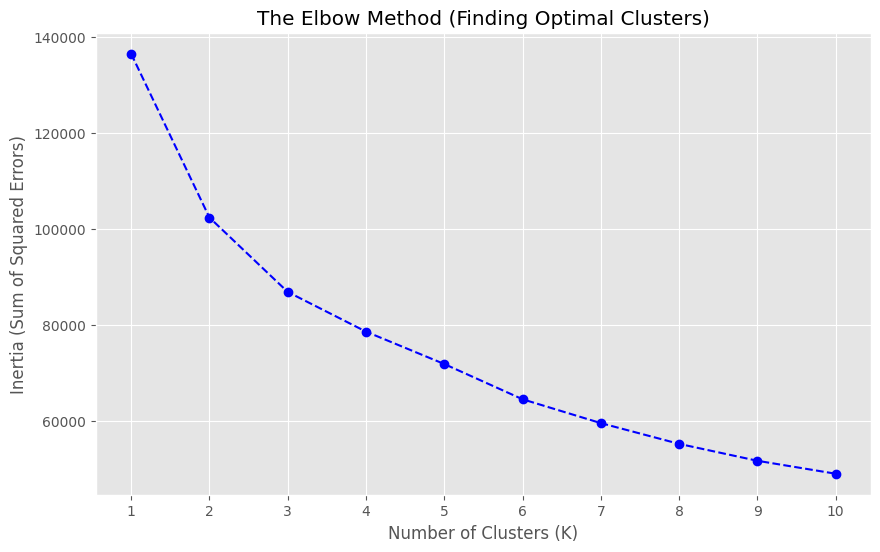

In [44]:
#Model Selection - The Elbow Method

# 1. List to store inertia (Sum of Squared Errors) for each K
inertia = []
k_range = range(1, 11)  # Test K from 1 to 10

print("--- Training K-Means Models (Finding Optimal K) ---")

# 2. Train K-Means for each K
for k in k_range:
    # Use the final scaled data (X_scaled)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='b')
plt.title('The Elbow Method (Finding Optimal Clusters)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()



--- Clustering Completed ---
Distribution of Drivers per Cluster:
cluster
2    4720
1    2165
3    1369
0     848
Name: count, dtype: int64


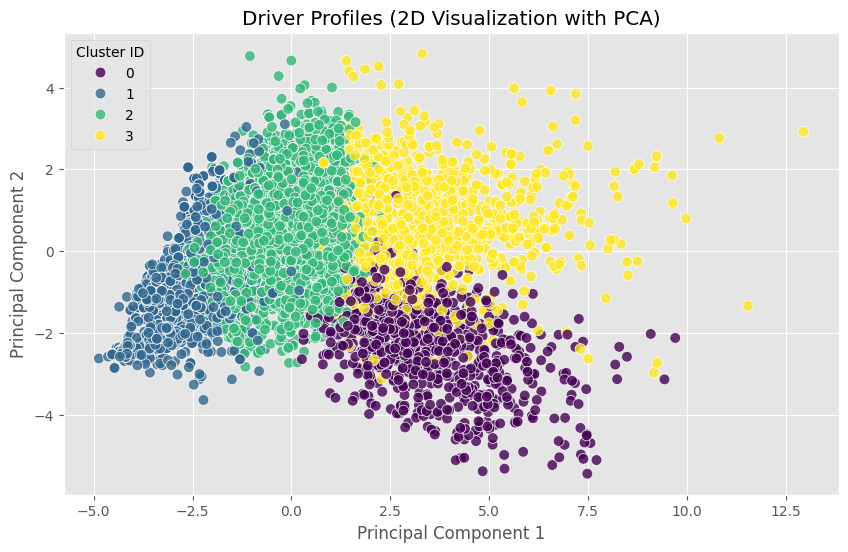


--- Cluster Profiles (Interpretation Table) ---
         moving_speed_kmh  weighted_risk_score  seatbelt_ratio  idle_ratio  \
cluster                                                                      
0                    2.27                52.61            0.01        0.90   
1                    1.54                11.58            0.00        0.66   
2                    3.24                26.93            0.01        0.96   
3                    3.90                91.07            0.01        0.92   

         is_fatigued  distance_traveled  count  
cluster                                         
0               0.90             207.05    848  
1               0.03              39.16   2165  
2               0.16              87.96   4720  
3               0.81             256.98   1369  


In [45]:
# Final Model Training & Profiling (K=4)

# 1. Apply K-Means with Optimal K=4 (Based on Elbow Method)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# Train on the scaled data
df_final_scaled['cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the ORIGINAL DataFrame for interpretation
df_eng['cluster'] = df_final_scaled['cluster'].values

print("--- Clustering Completed ---")
print(f"Distribution of Drivers per Cluster:\n{df_eng['cluster'].value_counts()}")


# 2. Visualize Clusters (using PCA to reduce dimensions to 2D)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0], 
    y=principal_components[:, 1], 
    hue=df_eng['cluster'], 
    palette='viridis', 
    s=60, 
    alpha=0.8
)
plt.title('Driver Profiles (2D Visualization with PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()


# 3. Cluster Profiling (The Identity Card)
print("\n--- Cluster Profiles (Interpretation Table) ---")
profile = df_eng.groupby('cluster')[[
    'moving_speed_kmh',      # Real Speed
    'weighted_risk_score',   # Risk Score
    'seatbelt_ratio',        # Safety Compliance
    'idle_ratio',            # Efficiency
    'is_fatigued',           # Long driving hours
    'distance_traveled'      # Workload
]].mean()

# Add the count of trips in each cluster
profile['count'] = df_eng['cluster'].value_counts()

print(profile.round(2))

--- 1. Clustering Quality (Internal Metric) ---
Clustering Silhouette Score: 0.235
(Interpretation: > 0.5 is good separation, > 0.25 is acceptable for behavioral data)

--- 2. Supervised Validation (Meeting Section 5 Requirements) ---

Classification Report (Model Accuracy):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       170
           1       0.98      1.00      0.99       433
           2       0.98      0.99      0.99       944
           3       0.97      0.95      0.96       274

    accuracy                           0.98      1821
   macro avg       0.98      0.98      0.98      1821
weighted avg       0.98      0.98      0.98      1821


--- Top Features Driving the Profiles ---
                Feature  Importance
3                  hour    0.170154
5         time_category    0.157660
1    overspeed_standard    0.099353
11  weighted_risk_score    0.094192
2             seat_belt    0.091323


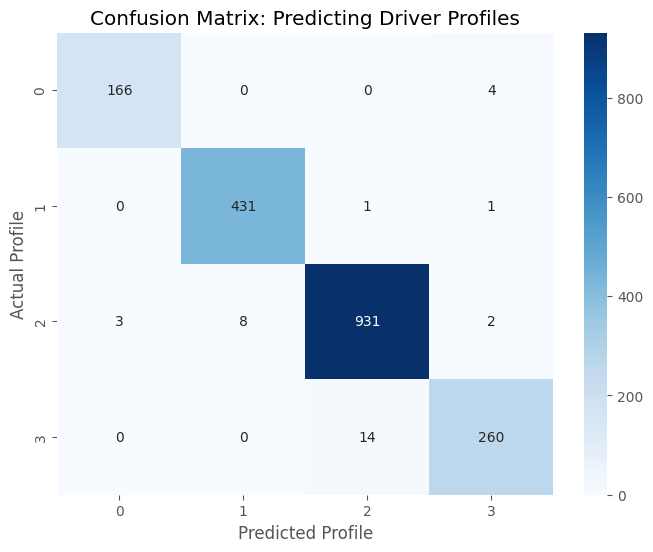

In [46]:
#  Model Evaluation (Clustering & Classification Check)

print("--- 1. Clustering Quality (Internal Metric) ---")
# Silhouette Score: Measures how well-separated the clusters are (-1 to 1)
# Note: Using a sample for speed if dataset is huge
sample_size = 10000 if len(X_scaled) > 10000 else len(X_scaled)
score = silhouette_score(X_scaled[:sample_size], df_eng['cluster'][:sample_size])
print(f"Clustering Silhouette Score: {score:.3f}")
print("(Interpretation: > 0.5 is good separation, > 0.25 is acceptable for behavioral data)")


print("\n--- 2. Supervised Validation (Meeting Section 5 Requirements) ---")
# This satisfies: "Train/Validation/Test splits" and "Tree-based baselines" requirements.

# A. Prepare Data
# X = Features (Scaled), y = Target (The Cluster ID)
X = df_final_scaled.drop(columns=['cluster', 'TARGET_is_risky'], errors='ignore')
y = df_eng['cluster']

# B. Train/Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# C. Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# D. Evaluate
y_pred = rf_model.predict(X_test)

print("\nClassification Report (Model Accuracy):")
print(classification_report(y_test, y_pred))

# E. Feature Importance (Why did the model choose these clusters?)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Top Features Driving the Profiles ---")
print(importance.head(5))

# F. Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Predicting Driver Profiles')
plt.xlabel('Predicted Profile')
plt.ylabel('Actual Profile')
plt.show()

--- Final Classification Summary ---
Driver_Profile
Inefficient (High Idle)    4720
Safe (Local)               2165
High Risk (Speeders)       1369
Fatigued (Long Haul)        848
Name: count, dtype: int64

✅ PROJECT COMPLETED! File saved as 'Driver_Risk_Analysis_Final.csv'


C:\Users\MSI Laptop\AppData\Local\Temp\ipykernel_28468\1718663534.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Driver_Profile', data=df_eng, palette='viridis', order=df_eng['Driver_Profile'].value_counts().index)


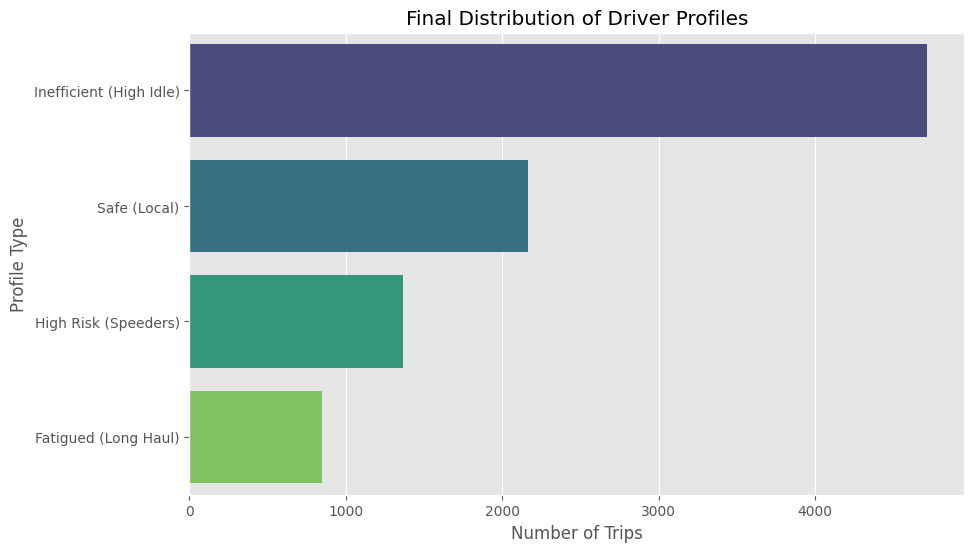

In [47]:
# 1. Map Cluster IDs to Human-Readable Names
# Based on your previous Profile Table analysis:
# Cluster 3 = Highest Risk & Speed
# Cluster 0 = High Fatigue (Long Haul)
# Cluster 1 = Safe (Low Risk)
# Cluster 2 = Inefficient (High Idle)

cluster_names = {
    3: 'High Risk (Speeders)',
    0: 'Fatigued (Long Haul)',
    1: 'Safe (Local)',
    2: 'Inefficient (High Idle)'
}

# Apply the names to a new column
df_eng['Driver_Profile'] = df_eng['cluster'].map(cluster_names)

# 2. Final Sanity Check
print("--- Final Classification Summary ---")
print(df_eng['Driver_Profile'].value_counts())

# 3. Export to CSV (This is your final deliverable)
df_eng.to_csv("Driver_Risk_Analysis_Final.csv", index=False)
print("\n✅ PROJECT COMPLETED! File saved as 'Driver_Risk_Analysis_Final.csv'")

# 4. Final Visualization for Report
plt.figure(figsize=(10, 6))
sns.countplot(y='Driver_Profile', data=df_eng, palette='viridis', order=df_eng['Driver_Profile'].value_counts().index)
plt.title('Final Distribution of Driver Profiles')
plt.xlabel('Number of Trips')
plt.ylabel('Profile Type')
plt.show()